In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# origin nms

In [6]:
def nms(detections: np.ndarray, confidence_threshold: float=0.25, score_threshold: float=0.2, nms_threshold: float=0.45) -> list:
    """后处理

    Args:
        detections (np.ndarray):                检测到的数据 [25200, 85]
        confidence_threshold (float, optional): prediction[4] 是否有物体得分阈值. Defaults to 0.25.
        score_threshold (float, optional):      nms分类得分阈值. Defaults to 0.2.
        nms_threshold (float, optional):        非极大值抑制iou阈值. Defaults to 0.45.

    """
    boxes = []  # [[xmin, ymin, w, h]]
    class_ids = []
    confidences = []
    for prediction in detections:
        confidence = prediction[4].item()           # 是否有物体得分
        if confidence >= confidence_threshold:      # 是否有物体预支
            classes_scores = prediction[5:]         # 取出所有类别id
            class_id = np.argmax(classes_scores)    # 找到概率最大的id
            if (classes_scores[class_id] > .25):    # 最大概率必须大于 0.25
                confidences.append(confidence)      # 保存置信度(注意保存的是confidence，不是classes_scores[class_id]),类别id,box
                class_ids.append(class_id)
                # center_x, center_y, w, h
                x, y, w, h = prediction[0].item(), prediction[1].item(), prediction[2].item(), prediction[3].item()
                xmin = x - (w / 2)
                ymin = y - (h / 2)
                box = [xmin, ymin, w, h]
                boxes.append(box)

    # nms
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold, nms_threshold)
    # t3 = time.time()

    # 根据nms返回的id获取对应的类别,置信度,box
    detections = []
    for i in indexes:
        j = i.item()
        boxes[j][2] += boxes[j][0] # w -> xmax
        boxes[j][3] += boxes[j][1] # h -> ymax
        detections.append({"class_index": class_ids[j], "confidence": confidences[j], "box": boxes[j]})
    # t4 = time.time()

    # print((t2 - t1)*1000, (t3 - t2)*1000, (t4 - t3)*1000)
    # 16.954421997070312 0.0 0.0 主要时间花在了遍历所有的框上面

    return detections

# speed nms

In [7]:
def nms1(detections: np.ndarray, confidence_threshold: float=0.25, score_threshold: float=0.2, nms_threshold: float=0.45) -> np.ndarray:
    """后处理

    Args:
        detections (np.ndarray):                检测到的数据 [25200, 85]
        confidence_threshold (float, optional): prediction[4] 是否有物体得分阈值. Defaults to 0.25.
        score_threshold (float, optional):      nms分类得分阈值. Defaults to 0.2.
        nms_threshold (float, optional):        非极大值抑制iou阈值. Defaults to 0.45.

    Returns:
        np.ndarray:
            [
                [class_index, confidences, xmin, ymin, xmax, ymax], np.float32
                ...
            ]
    """
    # 加速优化写法
    # 通过置信度过滤一部分框
    detections     = detections[detections[:, 4] > confidence_threshold]
    # 位置坐标
    loc            = detections[:, :4]
    # 置信度
    confidences    = detections[:, 4]
    # 分类
    cls            = detections[:, 5:]
    # 最大分类index
    max_cls_index  = cls.argmax(axis=-1)
    # 最大分类score
    max_cls_score  = cls.max(axis=-1)

    # 位置
    boxes          = loc[max_cls_score > .25]
    # 置信度
    confidences    = confidences[max_cls_score > .25]
    # 类别index
    class_index    = max_cls_index[max_cls_score > .25]

    # [center_x, center_y, w, h] -> [x_min, y_min, w, h]
    boxes[:, 0:2] -= boxes[:, 2:4] / 2

    # nms
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold, nms_threshold)

    # nms过滤
    boxes = boxes[indexes]
    # [x_min, y_min, w, h] -> [x_min, y_min, x_max, y_max]
    boxes[:, 2:4] += boxes[:, 0:2]

    # 防止框超出图片边界, 前面判断为True/False,后面选择更改的列,不选择更改的列会将整行都改为0
    boxes[boxes[:, 0] < 0.0, 0] = 0.0
    boxes[boxes[:, 1] < 0.0, 1] = 0.0
    boxes[boxes[:, 2] > 640, 2] = 640
    boxes[boxes[:, 3] > 640, 3] = 640

    # [
    #   [class_index, confidences, xmin, ymin, xmax, ymax],
    #   ...
    # ]
    detections = np.concatenate((np.expand_dims(class_index[indexes], 1), np.expand_dims(confidences[indexes], 1), boxes), axis=-1)

    return detections

In [100]:
x = np.random.uniform(0, 1, (25200, 85))
x.shape

(25200, 85)

In [101]:
%timeit nms(x, 0.25, 0.2, 0.45)

216 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
r = nms(x, 0.25, 0.2, 0.45)
len(r)

2497

In [103]:
%timeit nms1(x, 0.25, 0.2, 0.45)

133 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
r = nms1(x, 0.25, 0.2, 0.45)
r.shape

(2497, 6)

# 分步骤测试

In [25]:
detections = np.random.uniform(0, 1, (25200, 85))
detections.shape

(25200, 85)

## 初步过滤数据,拆分数据

In [26]:
# 通过置信度过滤一部分框
detections = detections[detections[:, 4] > 0.25]
detections.shape

(18939, 85)

In [27]:
# 置信度
confidences = detections[:, 4]
confidences.shape

(18939,)

In [28]:
# 位置坐标
loc = detections[:, :4]
loc.shape

(18939, 4)

In [29]:
# 分类
cls = detections[:, 5:]
cls.shape

(18939, 80)

In [30]:
# 最大分类index
max_cls_index = cls.argmax(axis=-1)
# 最大分类score
max_cls_score = cls.max(axis=-1)
max_cls_index.shape, max_cls_score.shape

((18939,), (18939,))

In [31]:
# 位置      (n, 4)
boxes = loc[max_cls_score > .25]
# 置信度    (n,)
confidences = confidences[max_cls_score > .25]
# 类别index (n,)
class_index = max_cls_index[max_cls_score > .25]
boxes.shape, confidences.shape, class_index.shape

((18939, 4), (18939,), (18939,))

In [32]:
# [center_x, center_y, w, h] -> [x_min, y_min, w, h]
boxes[:, 0] -= boxes[:, 2] / 2
boxes[:, 1] -= boxes[:, 3] / 2

## nms

In [33]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.1)
len(indexes)

504

## 根据nms的index获取数据

In [34]:
# xmin, ymin, w, h
boxes[indexes].shape

(504, 4)

In [35]:
# object score
confidences[indexes].shape

(504,)

In [36]:
# max cls index
max_cls_index[indexes].shape, max_cls_index[indexes][0]

((504,), 59)

In [37]:
# max cls score
max_cls_score[indexes].shape, max_cls_score[indexes][0]

((504,), 0.9909019186204976)

In [38]:
# 获取进过mns的所有score
test_scores = detections[indexes, 5:]
test_scores.shape

(504, 80)

In [39]:
# 14是上面max_cls_index的第0个结果,返回的是max_cls_score的第0个结果
test_scores[0, max_cls_index[indexes][0]]

0.9909019186204976

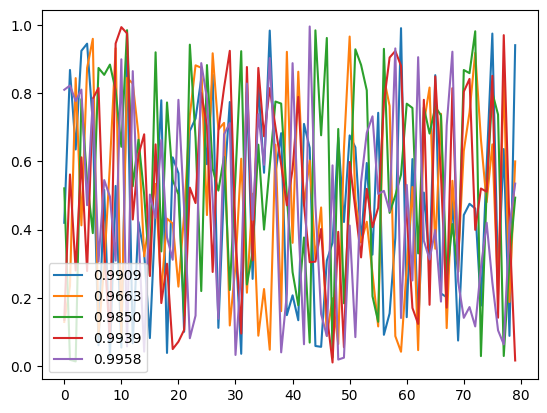

In [43]:
for i, line in enumerate(test_scores):
    if i >= 5:
        break
    plt.plot(range(80), line, label=f"{'{:.4f}'.format(line.max())}")
    plt.legend()

In [44]:
def np_sigmoid(array: np.ndarray):
    return 1 / (1 + np.e ** (-array))

In [45]:
np_sigmoid(test_scores[0]).max()

0.7292660313515115

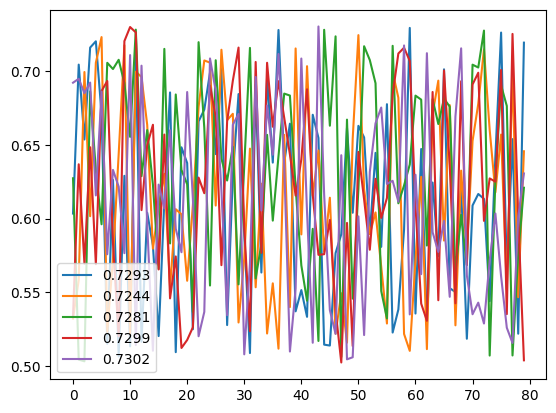

In [47]:
for i, line in enumerate(np_sigmoid(test_scores)):
    if i >= 5:
        break
    plt.plot(range(80), line, label=f"{'{:.4f}'.format(line.max())}")
    plt.legend()

## 真实得分查看分布

In [48]:
test_scores1 = np.array([[9.92298007e-01, 5.94705343e-04, 1.52498484e-03, 4.71055508e-04,
                          1.25139952e-04, 2.48819590e-04, 1.77472830e-04, 4.19676304e-04,
                          1.56432390e-04, 1.56074762e-04, 2.33501196e-04, 1.12235546e-04,
                          3.06963921e-04, 2.58952379e-04, 1.33782625e-04, 1.80065632e-04,
                          2.42739916e-04, 2.20775604e-04, 1.20043755e-04, 1.39176846e-04,
                          1.50918961e-04, 1.24990940e-04, 1.19805336e-04, 1.50412321e-04,
                          2.08848715e-03, 2.03609467e-04, 2.37098336e-03, 2.01314688e-04,
                          6.83397055e-04, 9.70363617e-05, 1.22755766e-04, 1.41888857e-04,
                          1.11311674e-04, 1.14291906e-04, 1.27583742e-04, 1.28090382e-04,
                          1.42902136e-04, 1.65402889e-04, 1.37954950e-04, 2.40027905e-04,
                          1.39147043e-04, 1.80035830e-04, 9.91225243e-05, 1.01894140e-04,
                          1.09255314e-04, 9.92417336e-05, 1.13755465e-04, 1.10715628e-04,
                          1.04665756e-04, 1.16825104e-04, 1.23977661e-04, 1.14649534e-04,
                          1.00553036e-04, 8.83042812e-05, 1.00016594e-04, 1.08301640e-04,
                          3.55690718e-04, 2.01344490e-04, 1.72346830e-04, 1.81853771e-04,
                          1.72674656e-04, 1.48266554e-04, 1.49786472e-04, 1.16109848e-04,
                          1.10775232e-04, 1.13159418e-04, 9.46223736e-05, 1.38521194e-04,
                          1.07884407e-04, 1.52140856e-04, 1.17599964e-04, 1.06424093e-04,
                          2.00748444e-04, 1.51216984e-04, 1.11490488e-04, 1.33633614e-04,
                          1.12771988e-04, 1.97231770e-04, 1.17868185e-04, 1.04278326e-04,],
                          [9.93473589e-01, 3.19302082e-04, 5.33282757e-04, 2.07483768e-04,
                          1.16944313e-04, 1.27461553e-03, 1.97827816e-04, 3.27676535e-04,
                          1.03801489e-04, 1.08659267e-04, 9.79602337e-05, 1.04308128e-04,
                          1.24037266e-04, 1.60455704e-04, 1.01774931e-04, 1.62065029e-04,
                          1.53422356e-04, 2.01374292e-04, 8.03470612e-05, 9.90033150e-05,
                          1.05679035e-04, 9.63211060e-05, 9.27448273e-05, 1.13844872e-04,
                          1.76745653e-03, 1.65522099e-04, 8.81579518e-03, 1.97499990e-04,
                          2.59131193e-04, 7.44163990e-05, 1.02490187e-04, 1.09553337e-04,
                          9.18209553e-05, 9.84966755e-05, 1.13904476e-04, 9.88841057e-05,
                          9.33110714e-05, 1.53243542e-04, 1.30265951e-04, 3.15904617e-04,
                          9.07480717e-05, 1.12563372e-04, 8.80658627e-05, 8.20457935e-05,
                          9.34004784e-05, 8.48472118e-05, 1.08659267e-04, 7.86185265e-05,
                          7.41481781e-05, 7.98702240e-05, 1.09106302e-04, 1.11371279e-04,
                          8.14497471e-05, 6.18398190e-05, 8.05258751e-05, 9.02116299e-05,
                          2.12937593e-04, 1.25050545e-04, 1.31279230e-04, 1.28000975e-04,
                          9.77516174e-05, 9.79900360e-05, 1.02579594e-04, 9.87648964e-05,
                          9.26852226e-05, 1.00404024e-04, 9.11355019e-05, 1.03980303e-04,
                          8.86917114e-05, 1.02221966e-04, 1.16527081e-04, 7.42673874e-05,
                          1.33454800e-04, 1.63167715e-04, 8.63969326e-05, 1.07198954e-04,
                          1.16318464e-04, 1.81853771e-04, 1.01685524e-04, 9.87350941e-05,],
                          [3.69042158e-04, 9.48309898e-05, 6.76393509e-04, 9.11056995e-05,
                          1.71303749e-04, 9.89608884e-01, 9.04291868e-04, 3.94734740e-03,
                          2.22951174e-04, 6.13331795e-05, 5.50448895e-05, 1.41054392e-04,
                          9.45031643e-05, 4.86075878e-05, 5.31077385e-05, 5.54621220e-05,
                          5.34057617e-05, 3.35007906e-04, 6.81877136e-05, 1.05708838e-04,
                          1.09791756e-04, 4.52995300e-05, 6.12735748e-05, 2.13831663e-04,
                          6.53862953e-05, 1.34497881e-04, 4.26173210e-05, 5.89787960e-05,
                          8.31484795e-05, 5.23030758e-05, 8.88109207e-05, 4.62234020e-05,
                          5.49554825e-05, 1.10775232e-04, 6.47306442e-05, 4.30643559e-05,
                          6.86645508e-05, 6.78002834e-05, 7.11381435e-05, 5.67138195e-05,
                          4.05907631e-05, 4.04417515e-05, 4.02927399e-05, 4.49419022e-05,
                          5.14090061e-05, 7.96616077e-05, 4.81009483e-05, 1.08480453e-04,
                          6.62505627e-05, 6.38663769e-05, 5.20348549e-05, 4.42266464e-05,
                          7.22408295e-05, 7.76946545e-05, 6.38663769e-05, 4.71770763e-05,
                          2.97427177e-05, 6.26444817e-05, 7.06613064e-05, 7.10785389e-05,
                          2.02089548e-04, 4.00543213e-05, 7.69495964e-05, 5.55515289e-05,
                          4.40776348e-05, 4.52995300e-05, 8.58604908e-05, 1.06006861e-04,
                          1.60843134e-04, 9.33110714e-05, 6.43730164e-05, 5.73694706e-05,
                          1.01983547e-04, 6.25550747e-05, 6.82473183e-05, 7.13765621e-05,
                          4.83095646e-05, 3.84747982e-05, 3.54647636e-05, 5.20348549e-05,],
                          [9.97963250e-01, 1.14619732e-04, 1.76548958e-04, 1.48087740e-04,
                          1.18702650e-04, 1.95652246e-04, 1.69545412e-04, 1.70797110e-04,
                          1.52617693e-04, 9.56654549e-05, 1.02251768e-04, 1.07377768e-04,
                          1.00433826e-04, 1.54048204e-04, 1.12503767e-04, 1.28924847e-04,
                          1.63167715e-04, 1.29699707e-04, 9.24170017e-05, 1.04010105e-04,
                          1.23441219e-04, 1.10358000e-04, 1.02609396e-04, 1.27047300e-04,
                          3.49640846e-04, 1.41233206e-04, 6.32971525e-04, 1.85817480e-04,
                          1.24871731e-04, 9.04202461e-05, 1.13338232e-04, 1.04069710e-04,
                          9.14335251e-05, 9.65297222e-05, 1.17480755e-04, 9.37283039e-05,
                          9.64999199e-05, 1.24186277e-04, 1.22129917e-04, 1.15066767e-04,
                          1.02251768e-04, 9.85860825e-05, 8.63373280e-05, 8.40425491e-05,
                          9.91523266e-05, 1.02639198e-04, 9.99569893e-05, 1.11877918e-04,
                          1.04099512e-04, 1.04367733e-04, 1.23769045e-04, 1.03712082e-04,
                          8.99732113e-05, 9.10758972e-05, 9.96589661e-05, 9.95993614e-05,
                          2.07841396e-04, 1.48385763e-04, 1.16646290e-04, 1.46299601e-04,
                          1.49875879e-04, 1.04129314e-04, 1.02847815e-04, 1.00970268e-04,
                          8.78572464e-05, 9.67383385e-05, 8.03172588e-05, 1.05291605e-04,
                          9.69767570e-05, 1.20997429e-04, 9.38475132e-05, 8.64267349e-05,
                          1.38998032e-04, 9.72151756e-05, 9.48905945e-05, 9.56356525e-05,
                          9.42647457e-05, 1.48773193e-04, 8.54730606e-05, 9.00030136e-05,],
                          [8.75338078e-01, 1.09934807e-03, 6.76900148e-04, 1.58831477e-03,
                          1.78009272e-04, 2.15381384e-04, 2.06857920e-04, 4.83959913e-04,
                          2.65955925e-04, 1.61051750e-04, 1.48624182e-03, 1.05261803e-04,
                          3.72439623e-04, 1.79773569e-03, 3.00607085e-03, 1.19698048e-03,
                          1.51061714e-02, 4.32203710e-02, 4.32837009e-03, 1.05960667e-02,
                          1.00705326e-02, 9.38653946e-04, 9.13977623e-04, 1.09654665e-03,
                          1.08649433e-02, 5.60283661e-04, 4.02248204e-02, 3.88324261e-04,
                          1.30397081e-03, 2.67863274e-04, 2.62975693e-04, 2.36123800e-04,
                          2.35378742e-04, 2.64078379e-04, 2.77668238e-04, 5.82695007e-04,
                          4.39137220e-04, 3.91334295e-04, 2.57819891e-04, 5.16533852e-04,
                          1.66207552e-04, 2.48044729e-04, 1.37448311e-04, 1.56998634e-04,
                          1.27524137e-04, 2.33530998e-04, 4.71442938e-04, 1.65402889e-04,
                          1.66505575e-04, 1.49101019e-04, 1.16884708e-04, 1.90764666e-04,
                          2.15351582e-04, 1.35421753e-04, 1.45882368e-04, 2.56150961e-04,
                          1.34313107e-03, 4.07665968e-04, 4.17649746e-04, 3.35276127e-04,
                          3.27974558e-04, 2.43902206e-04, 1.64628029e-04, 1.88380480e-04,
                          1.07914209e-04, 1.87873840e-04, 8.42511654e-05, 2.59876251e-04,
                          9.55462456e-05, 2.22146511e-04, 1.29073858e-04, 1.25259161e-04,
                          1.64210796e-04, 2.73466110e-04, 1.57684088e-04, 2.69412994e-04,
                          1.67697668e-04, 2.95323133e-03, 1.68651342e-04, 1.31547451e-04,]])

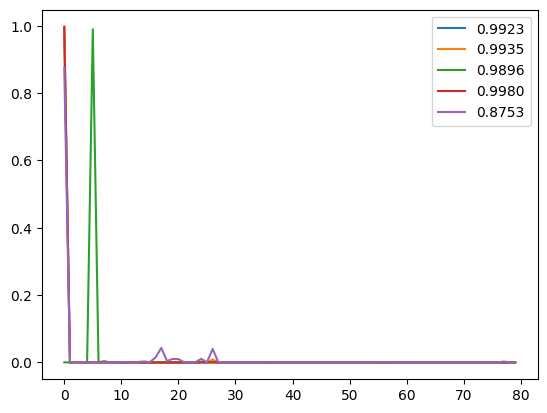

In [50]:
# 从图中可以看出大部分得分在一个值
for i, line in enumerate(test_scores1):
    plt.plot(range(80), line, label=f"{'{:.4f}'.format(line.max())}")
    plt.legend()

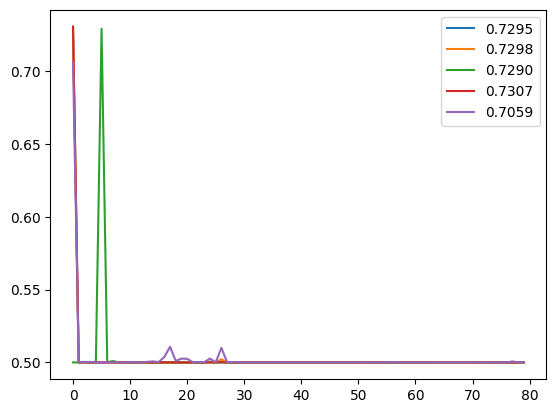

In [51]:
# sigmoid没有效果
for i, line in enumerate(np_sigmoid(test_scores1)):
    plt.plot(range(80), line, label=f"{'{:.4f}'.format(line.max())}")
    plt.legend()

In [11]:
# 这个结果没经过nms,所以可以看到多个得分高的,但是最终被nms过滤掉了
test_scores2 = np.array([[0.10615314, 0.00370126, 0.02392893, 0.00158053, 0.00155699, 0.00253002,
                            0.00297853, 0.0041779 , 0.00321301, 0.39096555, 0.00286851, 0.01211802,
                            0.00611152, 0.00380492, 0.03869507, 0.00168552, 0.00107855, 0.00252746,
                            0.00321454, 0.0012715 , 0.00075036, 0.00043589, 0.00092405, 0.0015508,
                            0.00293206, 0.01151434, 0.00820964, 0.00354706, 0.00202937, 0.00097045,
                            0.00131942, 0.00065515, 0.0082475 , 0.00451994, 0.00098702, 0.00078806,
                            0.00103882, 0.00122463, 0.0014433 , 0.02179747, 0.00464433, 0.01126828,
                            0.0015574 , 0.00456563, 0.00268626, 0.00275893, 0.0166862 , 0.00571843,
                            0.00072195, 0.02402215, 0.00158768, 0.00191813, 0.00069782, 0.000924,
                            0.00227842, 0.0017554 , 0.01734008, 0.00077853, 0.03754289, 0.00058469,
                            0.00212386, 0.00096439, 0.00395899, 0.00046684, 0.00085193, 0.00310041,
                            0.00063995, 0.00506411, 0.00114314, 0.00081654, 0.00060281, 0.0014604,
                            0.00113673, 0.01469599, 0.03617367, 0.00660287, 0.00161258, 0.00228886,
                            0.0008227 , 0.00132625,],
                            [0.13344648, 0.00537074, 0.05045162, 0.00228957, 0.00229464, 0.003012,
                            0.00369618, 0.00584781, 0.00537135, 0.2985728 , 0.00215376, 0.00960508,
                            0.00480117, 0.00719323, 0.04642272, 0.00172779, 0.0013605 , 0.00282397,
                            0.00467705, 0.00187259, 0.00096756, 0.00064407, 0.00117832, 0.00161,
                            0.00403842, 0.01336286, 0.00759443, 0.00404343, 0.00243892, 0.0014373,
                            0.00218083, 0.00088771, 0.00835483, 0.0049995 , 0.00134363, 0.00116384,
                            0.00162665, 0.00193011, 0.00151905, 0.01334526, 0.00553018, 0.01336389,
                            0.00242504, 0.00459118, 0.00355405, 0.00435505, 0.01046036, 0.00563498,
                            0.00101369, 0.02127957, 0.0018855 , 0.00317702, 0.00105144, 0.00139801,
                            0.00410081, 0.00230359, 0.02690013, 0.00105125, 0.02350421, 0.00088247,
                            0.00429057, 0.00099958, 0.00374812, 0.00060192, 0.00118266, 0.00468549,
                            0.00096115, 0.00737223, 0.00150084, 0.0011498 , 0.00082953, 0.0028578,
                            0.00145194, 0.01641619, 0.03684423, 0.00456083, 0.00161329, 0.00261433,
                            0.00097165, 0.00143619,],
                            [0.11537936, 0.00482884, 0.04202347, 0.00195419, 0.00244382, 0.00217894,
                            0.00232673, 0.00454532, 0.0039915 , 0.1511194 , 0.00147659, 0.00667032,
                            0.00324349, 0.00771282, 0.04945563, 0.00184005, 0.00131527, 0.00259113,
                            0.00435295, 0.00192524, 0.00096764, 0.0006121 , 0.00114644, 0.00147467,
                            0.00582948, 0.01215184, 0.01138845, 0.00672363, 0.00332915, 0.00165545,
                            0.00281647, 0.00099363, 0.01362978, 0.00607956, 0.00157739, 0.00152633,
                            0.00228401, 0.0023298 , 0.00180023, 0.01331933, 0.00583144, 0.01442981,
                            0.00405562, 0.00782942, 0.0044536 , 0.00350447, 0.00594093, 0.00529837,
                            0.00087494, 0.01486006, 0.00226952, 0.00469164, 0.00096626, 0.00150968,
                            0.003437  , 0.00225604, 0.03098693, 0.0012916 , 0.01854173, 0.00100086,
                            0.00438038, 0.00095203, 0.0038548 , 0.00103886, 0.00159753, 0.00602904,
                            0.00145373, 0.00925789, 0.00123695, 0.00112229, 0.00065372, 0.00327472,
                            0.00141855, 0.02084718, 0.02861905, 0.00432163, 0.00205636, 0.00193697,
                            0.00086853, 0.0016774 ,],
                            [0.13761377, 0.00489297, 0.03656099, 0.00174431, 0.00229494, 0.00160557,
                            0.00167707, 0.00312044, 0.0032107 , 0.14639921, 0.0013611 , 0.00616389,
                            0.00303925, 0.00709276, 0.06639381, 0.00157961, 0.001289  , 0.00225159,
                            0.00440944, 0.00191766, 0.00089789, 0.00058767, 0.00126921, 0.00153261,
                            0.00576553, 0.00936008, 0.00890409, 0.00672092, 0.00302705, 0.00163121,
                            0.00353986, 0.00103629, 0.01686516, 0.00705525, 0.00149337, 0.00149428,
                            0.0022033 , 0.00239013, 0.00160515, 0.01256962, 0.00617014, 0.0151046,
                            0.00519172, 0.0081378 , 0.0045985 , 0.00277572, 0.0037714 , 0.00452166,
                            0.00069351, 0.01287292, 0.00213063, 0.00569576, 0.00089655, 0.00136464,
                            0.00298209, 0.0019011 , 0.02760033, 0.00115567, 0.01161464, 0.00093251,
                            0.00372509, 0.00091818, 0.00301332, 0.00105041, 0.00190431, 0.00674829,
                            0.00154626, 0.01014009, 0.00111249, 0.00096033, 0.00056912, 0.00346137,
                            0.00120168, 0.02092475, 0.03070452, 0.00362086, 0.00202998, 0.0014697,
                            0.00080925, 0.0016627 ,],
                            [0.13663734, 0.00548982, 0.03279336, 0.00198346, 0.00194653, 0.00125882,
                            0.00132701, 0.00285315, 0.00308703, 0.07093956, 0.00118089, 0.0047447,
                            0.0028662 , 0.00580669, 0.06176294, 0.00147773, 0.00139367, 0.002366,
                            0.00453275, 0.00188882, 0.00083756, 0.00056396, 0.00120902, 0.0013668,
                            0.00487029, 0.00559038, 0.00725556, 0.01007271, 0.0027092 , 0.00163057,
                            0.00334012, 0.00099185, 0.0186146 , 0.00582897, 0.00158099, 0.00158864,
                            0.00194174, 0.00212001, 0.00183498, 0.01786917, 0.01943766, 0.02573522,
                            0.00762604, 0.00845292, 0.00649917, 0.00355166, 0.00423613, 0.00472621,
                            0.00090865, 0.01394044, 0.00214106, 0.00530135, 0.00101503, 0.00164693,
                            0.00429182, 0.00257552, 0.03843387, 0.00114884, 0.0095429 , 0.00084088,
                            0.00347346, 0.00093314, 0.00305824, 0.00101609, 0.00201458, 0.0080972,
                            0.00148807, 0.01109662, 0.00112513, 0.00100863, 0.00054734, 0.0030786,
                            0.00134191, 0.02728472, 0.0379956 , 0.00445495, 0.00257948, 0.00187484,
                            0.00081898, 0.00194498,]])

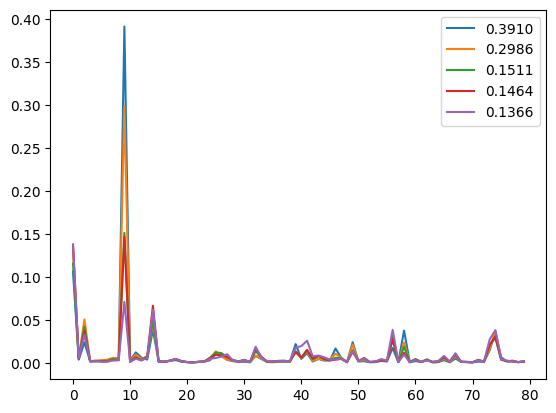

In [52]:
# 可以看到分布惊人一致,猜测检测的是同一个目标
for i, line in enumerate(test_scores2):
    plt.plot(range(80), line, label=f"{'{:.4f}'.format(line.max())}")
    plt.legend()